# Analyze Devices on Shodan

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [130]:
import matplotlib

In [1]:
!pip install shodan

     |████████████████████████████████| 53 kB 3.0 MB/s eta 0:00:01
  Created wheel for shodan: filename=shodan-1.28.0-py3-none-any.whl size=47645 sha256=390f0d71b964af9773865816becdda412aa9da2e6e31caed5e6a69b15b668473
  Stored in directory: /Users/animcogn/Library/Caches/pip/wheels/94/0f/00/af0b64ee662b8f0475bee4cab1334e4b25f074f2b388aa7eb2
Successfully built shodan


In [326]:
# All dod subnets (sourced from masscan)
dod_str = """
6.0.0.0/8
7.0.0.0/8
11.0.0.0/8
21.0.0.0/8
22.0.0.0/8
26.0.0.0/8
28.0.0.0/8
29.0.0.0/8
30.0.0.0/8
33.0.0.0/8
55.0.0.0/8
205.0.0.0/8
214.0.0.0/8
215.0.0.0/8
"""
dod = dod_str.strip().split('\n')
print(dod)

['6.0.0.0/8', '7.0.0.0/8', '11.0.0.0/8', '21.0.0.0/8', '22.0.0.0/8', '26.0.0.0/8', '28.0.0.0/8', '29.0.0.0/8', '30.0.0.0/8', '33.0.0.0/8', '55.0.0.0/8', '205.0.0.0/8', '214.0.0.0/8', '215.0.0.0/8']


In [327]:
# These are subnets we want to ignore
# 205.x.x.x has over 21 million hosts indexed on Shodan
ignore_list_str = """
205.0.0.0/8
"""
ignore_list = ignore_list_str.strip().split('\n')
[dod.remove(item) for item in ignore_list]
dod

['6.0.0.0/8',
 '7.0.0.0/8',
 '11.0.0.0/8',
 '21.0.0.0/8',
 '22.0.0.0/8',
 '26.0.0.0/8',
 '28.0.0.0/8',
 '29.0.0.0/8',
 '30.0.0.0/8',
 '33.0.0.0/8',
 '55.0.0.0/8',
 '214.0.0.0/8',
 '215.0.0.0/8']

# Setup Shodan

In [2]:
import shodan

# Configuration
API_KEY = 'xxx'

# Setup the api
api = shodan.Shodan(API_KEY)

# Get count of devices

In [26]:
# Wrap the request in a try/ except block to catch errors
devs = []
try:
        # Search Shodan
        for subnet in dod:
            results = api.search(f'net:{subnet}')
            # Show the results
            print(f'Results found: {results.get("total")} @ {subnet}')

except shodan.APIError as e:
        print('Error: {}'.format(e))
        

Results found: 24 @ 6.0.0.0/8
Results found: 1 @ 7.0.0.0/8
Results found: 43 @ 11.0.0.0/8
Results found: 0 @ 21.0.0.0/8
Results found: 46 @ 22.0.0.0/8
Results found: 1 @ 26.0.0.0/8
Results found: 1 @ 28.0.0.0/8
Results found: 78 @ 29.0.0.0/8
Results found: 12 @ 30.0.0.0/8
Results found: 0 @ 33.0.0.0/8
Results found: 7 @ 55.0.0.0/8
Results found: 21453074 @ 205.0.0.0/8
Results found: 2766 @ 214.0.0.0/8
Results found: 33 @ 215.0.0.0/8


# Get info on hosts

In [152]:
# Wrap the request in a try/ except block to catch errors
subnet_hosts = {} # Map subnet => ips[]
ip_host_banners = {} # ip => host banner data
try:
    # Search Shodan
    for subnet in dod:
        
        print(f'searching {subnet}')

        # Iterate through hosts
        results = api.search_cursor(f'net:{subnet}')
        for host in results:

            # Grab lists
            hosts = subnet_hosts.get(subnet, [])
            
            # Append to list
            hosts.append(host.get('ip_str'))
            
            # Dump back to dict
            subnet_hosts[subnet] = hosts
            
            # Save info in case we need it
            ip_host_banners[host.get('ip_str')] = host

except shodan.APIError as e:
        print('Error: {}'.format(e))

searching 7.0.0.0/8
searching 21.0.0.0/8
searching 30.0.0.0/8
searching 33.0.0.0/8
searching 22.0.0.0/8
searching 11.0.0.0/8
searching 214.0.0.0/8
searching 28.0.0.0/8
searching 29.0.0.0/8
searching 215.0.0.0/8
searching 55.0.0.0/8
searching 6.0.0.0/8
searching 26.0.0.0/8


# Collect service host Information

In [153]:
host_information = {}
# Loop subnets
for subnet, hosts in subnet_hosts.items():
    
    print(f'searching {subnet}')

    # Loop hosts
    for ip in hosts:
        
        host_info = None
        try:
            host_info = api.host(ip)
        except shodan.APIError as e:
            pass
#             print('Error: {}'.format(e))
            
        host_information[ip] = host_info



searching 7.0.0.0/8
searching 30.0.0.0/8
searching 22.0.0.0/8
searching 11.0.0.0/8
searching 214.0.0.0/8
searching 28.0.0.0/8
searching 29.0.0.0/8
searching 215.0.0.0/8
searching 55.0.0.0/8
searching 6.0.0.0/8


# Save to file

In [154]:
with open('all_host_info2', 'w+') as f:
    json.dump(host_information, f)
    
with open('ip_host_banners2', 'w+') as f:
    json.dump(ip_host_banners, f)
    
with open('subnet_hosts2', 'w+') as f:
    json.dump(subnet_hosts, f)

# Load from file

In [68]:
with open('all_host_info', 'r') as f:
    host_information = json.load(f)
    
with open('ip_host_banners', 'r') as f:
    ip_host_banners = json.load(f)
    
with open('subnet_hosts', 'r') as f:
    subnet_hosts = json.load(f)

# Classify our data
In this experiment, we're specifically looking for the following services only:
- Cisco Meeting App
- SIP
- BigIP

This is somewhat of a crude classify method but sufficient for this project.

In [156]:
# Loop through all ip addresses
counter = {}
# build a pandas dataframe
ips = []
service_types = []
for subnet, hosts in subnet_hosts.items():
    for ip in hosts:
        # We always have list banner data, so fall back to that if necessary
        host_data = str(host_information.get(ip) or '') + str(ip_host_banners[ip])
        
        # Convert all service data to lowercase and remove spaces for consistent searches
        host_services = host_data.lower().replace(' ','')

        service_type = 'other'
        if ("ciscomeetingapp" in host_services):
            counter["cisco meeting app"] = counter.get("cisco meeting app", 0) + 1
            service_type = 'cisco meeting app'
        
        elif("sip" in host_services):
            counter["sip"] = counter.get("sip", 0) + 1
            service_type = 'sip'
        
        elif ("bigip" in host_services or "big-ip" in host_services):
            counter["big ip"] = counter.get("bigip", 0) + 1
            service_type = 'bigip'
            
        # Pandas
        ips.append(ip)
        service_types.append(service_type)

chart = { 'ip': ips, 'service_types': service_types }

# Graph our data

In [157]:
df = pd.DataFrame(chart)

In [158]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 8}

matplotlib.rc('font', **font)

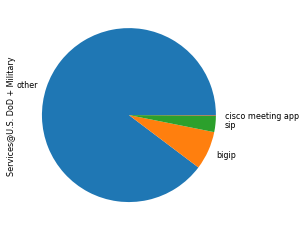

In [159]:
df.value_counts('service_types').plot.pie(label='Services@U.S. DoD + Military').get_figure().savefig('services.png', dpi=300)

In [160]:
df.value_counts('service_types')

service_types
other                2112
bigip                 168
sip                    72
cisco meeting app       2
dtype: int64

In [125]:
df.groupby('service_types').sum()

,ips
service_types,
bigip,215.67.62.100215.67.62.100215.67.62.104
cisco meeting app,6.64.136.96.64.151.9
other,30.1.0.8230.30.30.230.30.2.630.1.0.22230.128.2...
sip,7.7.7.1811.48.250.1816.64.157.696.64.142.126.6...


# Sort by Subet

In [182]:
# Get an iterable for our ordered service types
service_types_iter = iter(service_types)

services_by_subnets = []

# Loop through subnets/hosts
for subnet, hosts in subnet_hosts.items():
    # Expand the iterable of ordered service types
    subnet_services = [next(service_types_iter) for host in hosts]

    f = pd.DataFrame({'ip': hosts, 'service_type': subnet_services})
    
    
    services_by_subnets.append(f['service_type'].value_counts().to_dict())
    
df_services_by_subnets = pd.DataFrame(services_by_subnets, index=subnet_hosts.keys())

In [183]:
df_services_by_subnets

,sip,other,bigip,cisco meeting app
7.0.0.0/8,1.0,NaN,NaN,NaN
30.0.0.0/8,NaN,12.0,NaN,NaN
22.0.0.0/8,NaN,37.0,NaN,NaN
11.0.0.0/8,1.0,43.0,NaN,NaN
214.0.0.0/8,51.0,1906.0,165.0,NaN
28.0.0.0/8,NaN,1.0,NaN,NaN
29.0.0.0/8,NaN,69.0,NaN,NaN
215.0.0.0/8,NaN,32.0,3.0,NaN
55.0.0.0/8,NaN,7.0,NaN,NaN
6.0.0.0/8,19.0,5.0,NaN,2.0


# Stacked Graph

In [340]:
plt.rcParams["figure.figsize"] = (9,6)

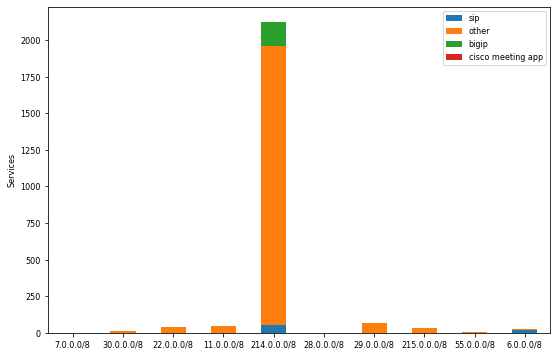

In [341]:
df_services_by_subnets.plot.bar(rot=0, stacked=True, ylabel='Services').get_figure().savefig('stacked.png', dpi=300)

In [155]:
len(ip_host_banners)

2155

# Label by Country Code

In [304]:
import numpy

In [305]:
# Make list of country code
countries = []

for host in ip_host_banners.values():
    country = host.get('location', {}).get('country_name', 'unknown')
    countries.append(country)

In [315]:
s_countries_freq = pd.Series(countries).value_counts()
s_countries_freq

[2124, 28, 2, 1]

In [317]:
f_countries = pd.DataFrame({'Country': s_countries_freq.keys(), 'IPs': list(s_countries_freq)})
f_countries

,Country,IPs
0,United States,2124
1,Germany,28
2,Netherlands,2
3,Indonesia,1


In [351]:
plt.rcParams["figure.figsize"] = (3,9)

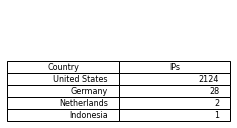

In [355]:
plt.rcParams["figure.figsize"] = (4,1)
fig, ax = plt.subplots()

#hide the axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

table = ax.table(cellText=f_countries.values, colLabels=f_countries.columns)
table.get_figure().savefig('table.png', dpi=300)

In [273]:
f_countries.value_counts().to_frame()

,0
Country,
United States,2124
Germany,28
Netherlands,2
Indonesia,1


In [356]:
f_subnet_hosts = pd.DataFrame({ 'subnet': subnet_hosts.keys(), 'device_count': [len(hosts) for hosts in subnet_hosts.values()] })
f_subnet_hosts

,subnet,device_count
0,7.0.0.0/8,1
1,30.0.0.0/8,12
2,22.0.0.0/8,37
3,11.0.0.0/8,44
4,214.0.0.0/8,2122
5,28.0.0.0/8,1
6,29.0.0.0/8,69
7,215.0.0.0/8,35
8,55.0.0.0/8,7
9,6.0.0.0/8,26


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling

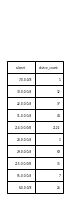

In [362]:
plt.rcParams["figure.figsize"] = (1,1)
fig, ax = plt.subplots()

#hide the axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

table = ax.table(cellText=f_subnet_hosts.values, colLabels=f_subnet_hosts.columns)
table.get_figure().savefig('table.png', dpi=300) 